# Анализ и прогнозирование временных рядов. Модель SARIMA/SARIMAX

Я использовал SARIMA модель и данные цен акций компании APPLE

Модель SARIMA($p, d, q, P, D, Q$)

Основные параметры модели:

- $p$ - порядок авторегрессии 
- $q$ - порядок скольящего среднего 
- $d$ - порядок интегрирования 
- $P$ - порядок сезонной авторегрессии 
- $Q$ - порядок сезонного скольящего среднего 
- $D$ - порядок сезонного интегрирования 

Последовательность действий

1. Данные
2. Параметры $d, p, q, D, Q, P$
3. Обучение
4. Прогноз


Данные взяты с https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231?select=AAPL_2006-01-01_to_2018-01-01.csv

In [1]:
import statsmodels
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import operator

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Данные
Cократил количество наблюдений путём применения функции, 
агригирующей данные к определенному периоду ( в данном случае к месяцу)

In [2]:
def custom_resampler(array_like):
    return np.mean(array_like)

In [3]:
apple = pd.read_csv("AAPL.csv", usecols=['Date', 'Close'], parse_dates=['Date'], index_col='Date')

apple = apple.resample('M').apply(custom_resampler)

ts_title = "apple stock"
print("{}. {} observations".format(ts_title, apple.shape[0]))
apple.head()

apple stock. 144 observations


,Close
Date,
2006-01-31,11.115500
2006-02-28,9.930526
2006-03-31,9.146957
2006-04-30,9.572632
2006-05-31,9.540455


Разложил временной ряд на компоненты. Регрессионный остаток не стационарен, что говорит о наличии зависимости не только от событий случайного процесса в прошлом, но и других внешних факторов.

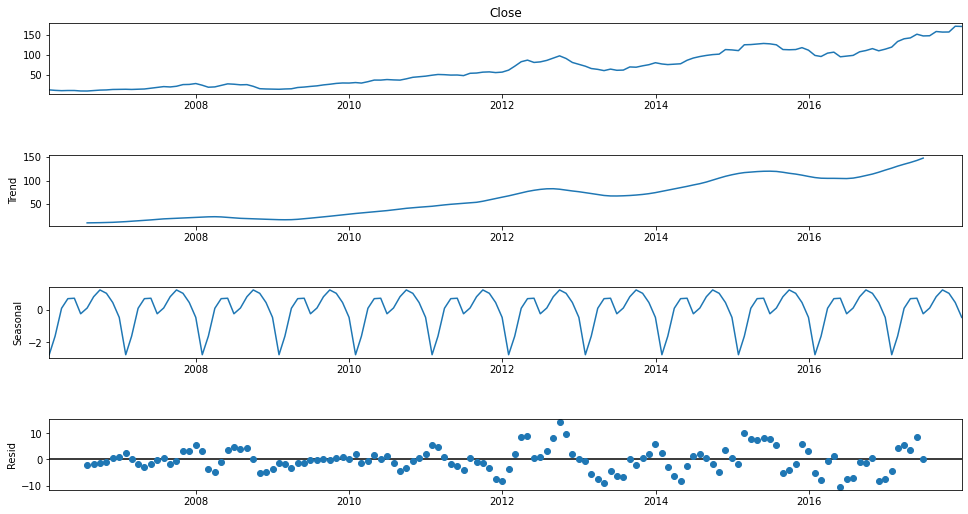

In [4]:
res = sm.tsa.seasonal_decompose(apple.Close.dropna())
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

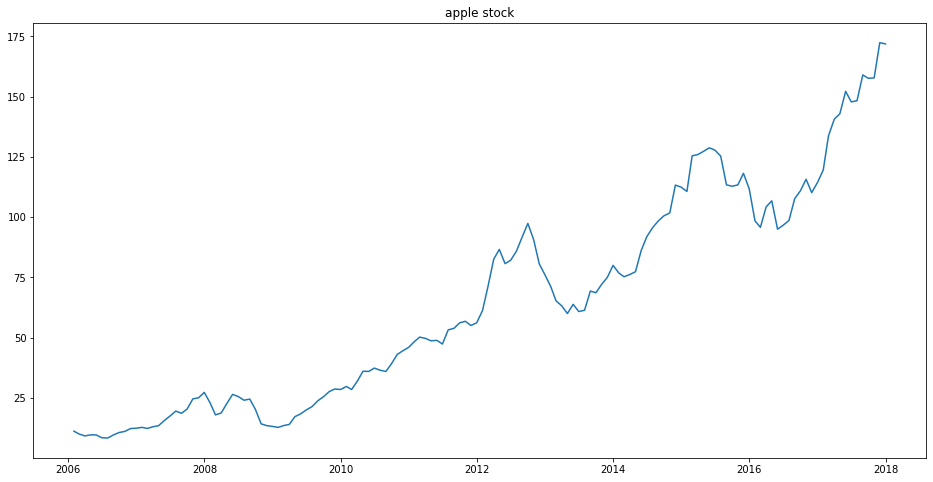

In [5]:
plt.figure(figsize=(16,8))
plt.plot(apple['Close'])
plt.title(ts_title)
plt.show()

# Подбор параметров

In [6]:
d = 0
ts = apple['Close']

# function "adfuller()" returns a tuple containing these values. The most interesting for us is the "p_value"
test_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(ts, regression='c')
print("d = {}. Stationarity test p_value: {}".format(d, p_value))

d = 0. Stationarity test p_value: 0.9880112449876928


In [7]:
d = 1
ts = apple['Close'].diff()

test_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(ts.dropna(), regression='c')
print("d = {}. Stationarity test p_value: {}".format(d, p_value))

d = 1. Stationarity test p_value: 6.756833828838878e-16


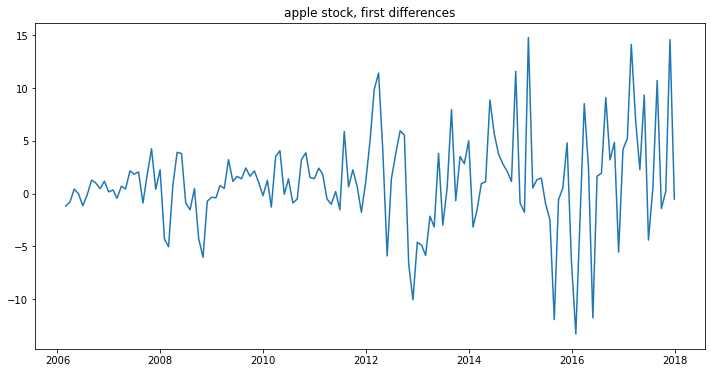

In [8]:
plt.figure(figsize=(12,6))
plt.plot(apple['Close'].diff())
plt.title(ts_title + ", first differences")
plt.show()

Продифференцированный один раз временной ряд обладает гетероскедатичностью, что говорит о нестационарности ряда.
Тогда применим преобразование Бокса-Кокса.

In [9]:
from scipy import stats
from scipy.special import boxcox, inv_boxcox

In [10]:
apple_ = pd.DataFrame(boxcox(apple['Close'], 0.4))

In [11]:
d = 0
ts = apple_

# function "adfuller()" returns a tuple containing these values. The most interesting for us is the "p_value"
test_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(ts, regression='c')
print("d = {}. Stationarity test p_value: {}".format(d, p_value))

d = 0. Stationarity test p_value: 0.8971089839770485


In [12]:
d = 1
ts = apple_.diff()

test_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(ts.dropna(), regression='c')
print("d = {}. Stationarity test p_value: {}".format(d, p_value))

d = 1. Stationarity test p_value: 4.18947584273546e-14


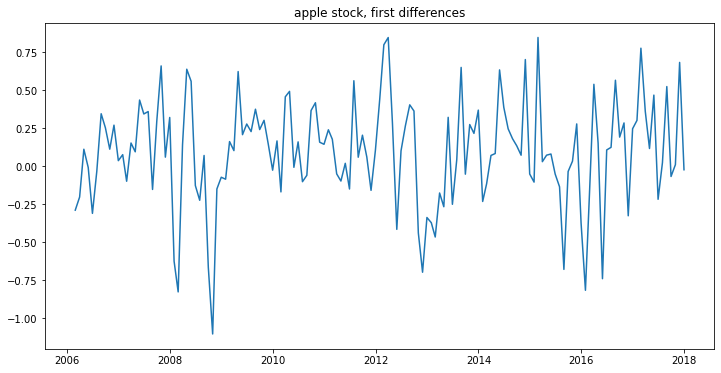

In [13]:
plt.figure(figsize=(12,6))
plt.plot(apple_.diff())
plt.title(ts_title + ", first differences")
plt.show()

Подобрав параметр преобразования Бокса-Кокса, видим, что ряд стал стационарным. 
Теперь переходим к оценке других параметров модели на основе функций автокореляции и частичной автокорреляции. 

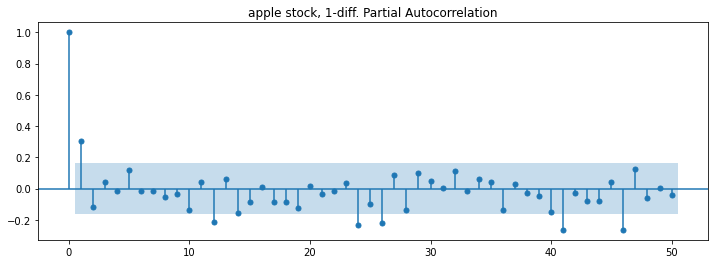

In [14]:
plot_pacf(ts.dropna(), title=ts_title + ", {}-diff. Partial Autocorrelation".format(d), lags=50).set_size_inches(12, 4)
plt.show()

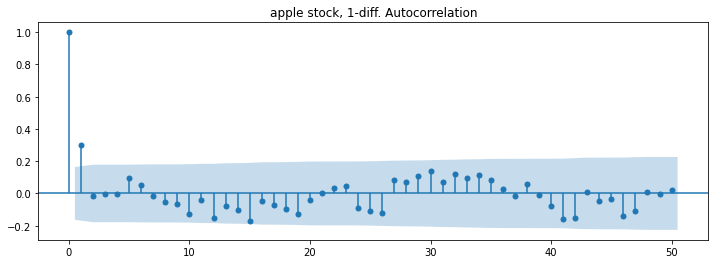

In [15]:
plot_acf(ts.dropna(), title=ts_title + ", {}-diff. Autocorrelation".format(d), lags=50).set_size_inches(12, 4)
plt.show()

# Обучение
По выше приведённым графикам подбираем диапозон, наиболее подходящих значений параметров, и проводим обучение по сетке для поиска наиболее оптимальной модели.

In [16]:
tr_start,tr_end = '2006-01-31','2016-12-31'
te_start,te_end = '2017-01-01','2017-12-31'
tra = apple_['Close'][tr_start:tr_end].dropna()
tes = apple_['Close'][te_start:te_end].dropna()

In [17]:
params_list = [[(p, d, q), (P, D, Q, 12)] for d in range(2) for D in range(2) for P in range(3) for Q in range(3) for p in range(3) for q in range(3)]
min_aic = 10000
max_llf = -10000
for param in params_list:
    srm = sm.tsa.statespace.SARIMAX(tra, 
                              order=param[0], 
                              seasonal_order=param[1], 
                              enforce_stationarity=False, 
                              enforce_invertibility=False).fit()
    if max_llf < srm.llf:
        max_llf = srm.llf
        best_srm_llf = srm
        
print(max_llf)
best_srm_llf.summary()      

-27.366875758841463


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  132
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 12)   Log Likelihood                 -27.367
Date:                            Wed, 24 Feb 2021   AIC                             72.734
Time:                                    08:24:15   BIC                             96.533
Sample:                                01-31-2006   HQIC                            82.376
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0831      0.255      0.325      0.745      -0.417       0.584
ar.L2          0.5778      0.139      4.151      0.000       0.305       0.851
ma.L1         -0.5285      0.733     -0.721      0.471      -1.966       0.908
ma.L2         -1.5258      0.986     -1.548      0.122      -3.458       0.406
ar.S.L12      -0.4846      0.189     -2.560      0.010      -0.856      -0.114
ar.S.L24      -0.3652      0.238     -1.535      0.125      -0.831       0.101
ma.S.L12       0.4631      0.217      2.130      0.033       0.037       0.889
ma.S.L24       0.1677      0.258      0.651      0.515      -0.337       0.673
sigma2         0.0404      0.040      1.000      0.317      -0.039       0.119
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.83   Prob(JB):                         0.72
Heteroskedasticity (H):               1.79   Skew:                            -0.05
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Прогноз
Предсказание на шаг

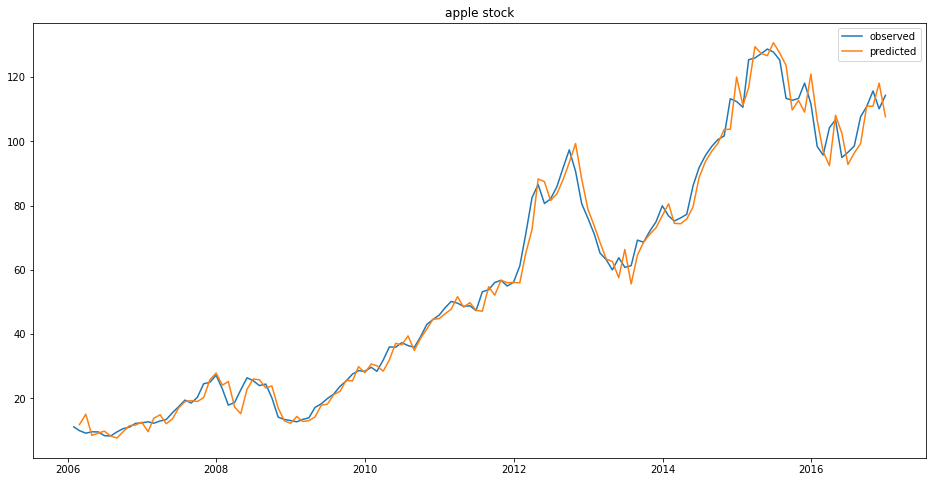

In [18]:
plt.figure(figsize=(16,8))
plt.plot(inv_boxcox(tra, 0.4), color='tab:blue', label='observed')
plt.plot(inv_boxcox(best_srm_llf.predict(start=1), 0.4), color='tab:orange', label='predicted')
# best_srmx_aic
# inv_boxcox(apple_['Close'], 0.4)
plt.legend()
plt.title(ts_title)
plt.show()

Генерируем выборку для тестирования

In [26]:
prediction_steps = 12
prediction_dates = pd.date_range(start='2017-01-01', periods=prediction_steps, freq='M')
prediction = pd.DataFrame(inv_boxcox(best_srm_llf.predict(start=prediction_dates[0], end=prediction_dates[-1]), 0.4),
                          index=prediction_dates)

prediction.head()

,predicted_mean
2017-01-31,120.286831
2017-02-28,115.302789
2017-03-31,118.071871
2017-04-30,116.958062
2017-05-31,119.721655


Делаем прогноз на 2 года вперёд

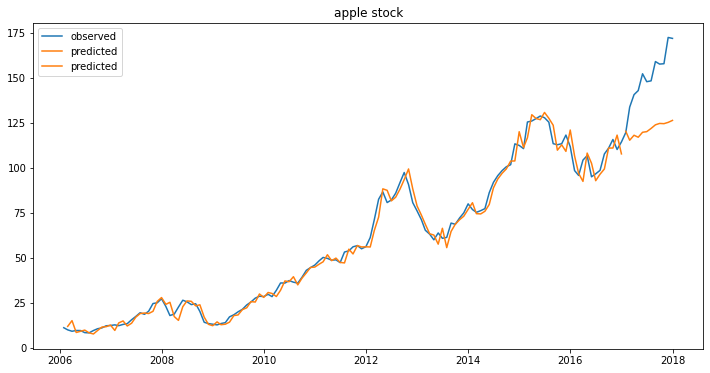

In [27]:
plt.figure(figsize=(12,6))
plt.plot(apple['Close'], color='tab:blue', label='observed')
plt.plot(inv_boxcox(best_srm_llf.predict(start=1), 0.4), color='tab:orange', label='predicted')
plt.plot(prediction, color='tab:orange', label='predicted')
plt.legend()
plt.title(ts_title)
plt.show()

Наконец, посмотрим, как ведёт себя ошибка предсказания в этом случае. Для этого мы отобразим на графике 95% доверительный интервал для предсказанных значений.

In [28]:
prediction_obj = best_srm_llf.get_prediction(start=prediction_dates[0], end=prediction_dates[-1], dynamic=0)
prediction = pd.DataFrame({'mean': inv_boxcox(prediction_obj.predicted_mean, 0.4), 'var': prediction_obj.var_pred_mean}, index=prediction_dates)

# Calculate 95% confidence interval
prediction['lower'] = prediction['mean'] - 1.96 * np.sqrt(prediction['var'])
prediction['upper'] = prediction['mean'] + 1.96 * np.sqrt(prediction['var'])
#prediction_obj

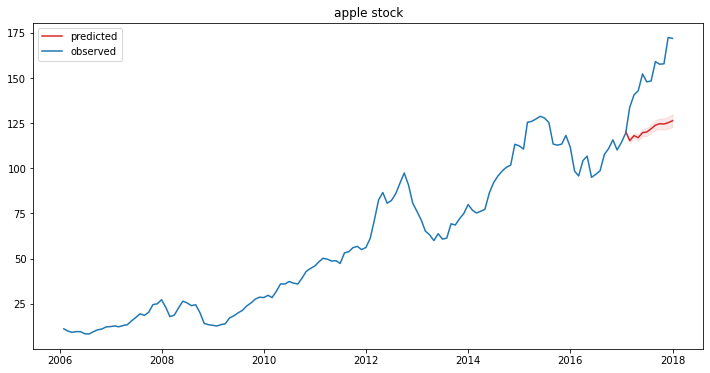

In [29]:
plt.figure(figsize=(12, 6))
plt.fill_between(prediction.index, prediction['lower'], prediction['upper'], alpha=0.1, color='tab:red')
plt.plot(prediction['mean'], color='tab:red', label='predicted')
plt.plot(apple['Close'], color='tab:blue', label='observed')
plt.legend()
plt.title(ts_title)
plt.show()

Далее изучим тривиальную зависимость месяца от цены акций и создадим набор признаков для обучения модели SARIMAX:

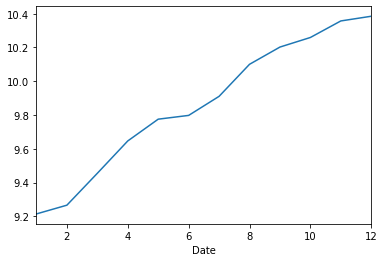

In [30]:
apple_.groupby(apple_.index.month).Close.mean().plot()
plt.show()

In [31]:
x = apple_.copy()
x['month'] = x.index.month
month_dummies = pd.get_dummies(x['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
x = pd.concat([x, month_dummies], axis=1, join_axes=[x.index]).drop(['month'],axis=1)
exog_train = x.drop(['Close'],axis = 1).dropna()
exog_test = x.drop(['Close'],axis = 1).dropna()
x.head()

,Close,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12
Date,,,,,,,,,,,,,
2006-01-31,4.051060,1,0,0,0,0,0,0,0,0,0,0,0
2006-02-28,3.762229,0,1,0,0,0,0,0,0,0,0,0,0
2006-03-31,3.559693,0,0,1,0,0,0,0,0,0,0,0,0
2006-04-30,3.670957,0,0,0,1,0,0,0,0,0,0,0,0
2006-05-31,3.662652,0,0,0,0,1,0,0,0,0,0,0,0


In [32]:
tr_start,tr_end = '2006-01-31','2016-12-31'
te_start,te_end = '2017-01-01','2017-12-31'
tra = x['Close'][tr_start:tr_end].dropna()
tes = x['Close'][te_start:te_end].dropna()
exog_train = x.drop(['Close'],axis = 1)[tr_start:tr_end].dropna()
exog_test = x.drop(['Close'],axis = 1)[te_start:te_end].dropna()
exog_full = x.drop(['Close'],axis = 1)

In [33]:
params_list = [[(p, d, q), (P, D, Q, 12)] for d in range(2) for D in range(2) for P in range(3) for Q in range(3) for p in range(3) for q in range(3)]
min_aic = 10000
max_llf = -10000
for param in params_list:
    srmx = sm.tsa.statespace.SARIMAX(tra, 
                              order=param[0], 
                              exog=exog_train, 
                              freq='M',
                              seasonal_order=param[1], 
                              enforce_stationarity=False, 
                              enforce_invertibility=False).fit()
    
    if max_llf < srmx.llf:
        max_llf = srmx.llf
        best_srmx_llf = srmx
print(max_llf)
best_srmx_llf.summary()      

-18.07544454157881


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(1, 0, 2, 12)   Log Likelihood                 -18.075
Date:                            Wed, 24 Feb 2021   AIC                             74.151
Time:                                    08:32:15   BIC                            124.394
Sample:                                01-31-2006   HQIC                            94.506
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month-1       -0.2025      0.047     -4.325      0.000      -0.294      -0.111
month-2       -0.1702      0.048     -3.512      0.000      -0.265      -0.075
month-3       -0.0471      0.053     -0.896      0.370      -0.150       0.056
month-4        0.0411      0.046      0.884      0.377      -0.050       0.132
month-5        0.0287      0.055      0.521      0.603      -0.079       0.137
month-6       -0.0201      0.056     -0.361      0.718      -0.129       0.089
month-7        0.0272      0.055      0.499      0.618      -0.080       0.134
month-8        0.1194      0.062      1.915      0.056      -0.003       0.242
month-9        0.1536      0.050      3.047      0.002       0.055       0.252
month-10       0.0815      0.057      1.434      0.152      -0.030       0.193
month-11       0.0155      0.055      0.281      0.779      -0.093       0.124
month-12      -0.0676      0.049     -1.379      0.168      -0.164       0.028
ar.L1          0.9910      0.011     89.527      0.000       0.969       1.013
ma.L1         -0.6366      0.533     -1.195      0.232      -1.681       0.408
ma.L2         -0.3719      0.165     -2.248      0.025      -0.696      -0.048
ar.S.L12      -0.1445      0.244     -0.591      0.554      -0.623       0.334
ma.S.L12      -0.6413      0.543     -1.182      0.237      -1.705       0.422
ma.S.L24      -0.5159      0.401     -1.288      0.198      -1.301       0.269
sigma2         0.0549      0.046      1.205      0.228      -0.034       0.144
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.55
Prob(Q):                              0.82   Prob(JB):                         0.46
Heteroskedasticity (H):               1.09   Skew:                            -0.29
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.2e+17. Standard errors may be unstable.
"""

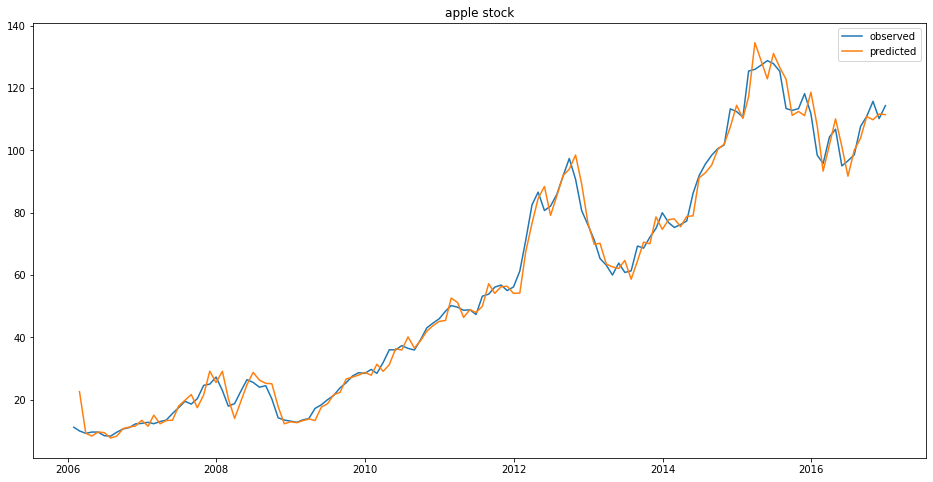

In [34]:
plt.figure(figsize=(16,8))
plt.plot(apple['Close'][tr_start:tr_end], color='tab:blue', label='observed')
plt.plot(inv_boxcox(best_srmx_llf.predict(start=1), 0.4), color='tab:orange', label='predicted')
# best_srmx_aic
# inv_boxcox(apple_['Close'], 0.4)
plt.legend()
plt.title(ts_title)
plt.show()

In [35]:
#exog_full = pd.concat([exog_train, exog_test], axis=0)
x_full = pd.concat([tra, tes], axis=0)

In [36]:
from sklearn.metrics import mean_squared_error
pred = inv_boxcox(best_srmx_llf.predict(te_start, te_end, exog = exog_test), 0.4)#[1:]
print('SARIMAX model MSE:{}'.format(mean_squared_error(tes, pred)))

SARIMAX model MSE:13185.812134734704


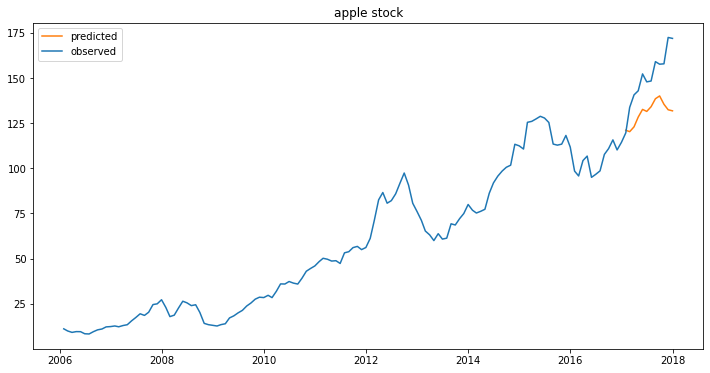

In [37]:
plt.figure(figsize=(12,6))
plt.plot(pred, color='tab:orange', label='predicted')
plt.plot(inv_boxcox(x_full, 0.4), color='tab:blue', label='observed')
plt.legend()
plt.title(ts_title)
plt.show()

In [39]:
prediction_dates = pd.date_range(start='2017-01-01', end='2017-12-31', freq='M')
prediction = pd.DataFrame(inv_boxcox(best_srmx_llf.predict(start=prediction_dates[0], end=prediction_dates[-1], exog=exog_test), 0.4),
                          index=prediction_dates)

prediction.head()

,predicted_mean
2017-01-31,121.047266
2017-02-28,120.265552
2017-03-31,122.932500
2017-04-30,128.334092
2017-05-31,132.586127


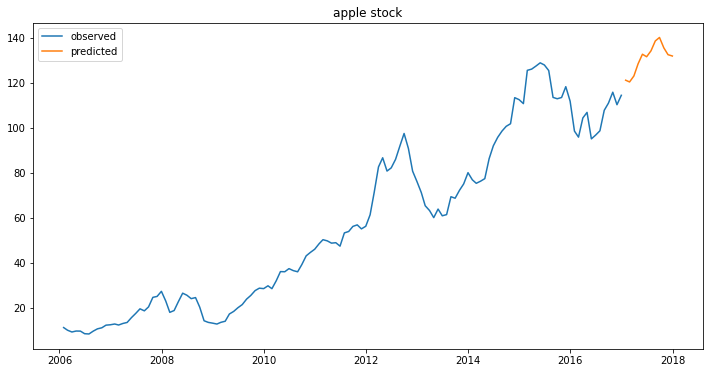

In [40]:
plt.figure(figsize=(12,6))
plt.plot(apple['Close'][tr_start:tr_end], color='tab:blue', label='observed')
plt.plot(prediction, color='tab:orange', label='predicted')
plt.legend()
plt.title(ts_title)
plt.show()

In [41]:
prediction_obj = best_srmx_llf.get_prediction(start=te_start, end=te_end, exog=exog_test, dynamic=0)
prediction = pd.DataFrame({'mean': inv_boxcox(prediction_obj.predicted_mean, 0.4), 'var': prediction_obj.var_pred_mean}, index=prediction_dates)

# Calculate 95% confidence interval
prediction['lower'] = prediction['mean'] - 1.96 * np.sqrt(prediction['var'])
prediction['upper'] = prediction['mean'] + 1.96 * np.sqrt(prediction['var'])
#prediction_obj

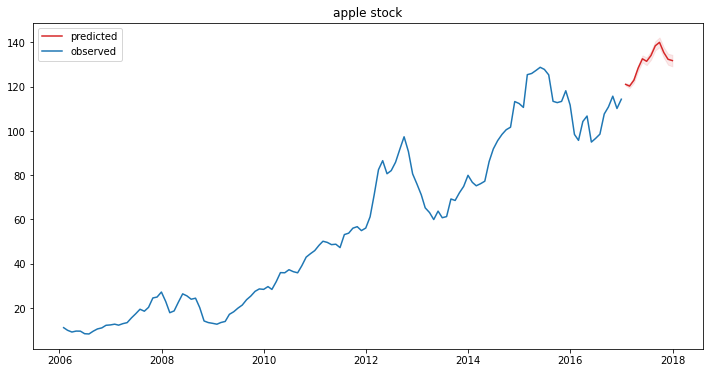

In [42]:
plt.figure(figsize=(12, 6))
plt.fill_between(prediction.index, prediction['lower'], prediction['upper'], alpha=0.1, color='tab:red')
plt.plot(prediction['mean'], color='tab:red', label='predicted')
plt.plot(apple['Close'][tr_start:tr_end], color='tab:blue', label='observed')
plt.legend()
plt.title(ts_title)
plt.show()

Низкая дисперсия, но большая смещённость.

## Выводы:
- SARIMAX даёт значительный прирост точности по сравнению с SARIMA, что видно и по графикам и по значениям ошибок.
- В SARIMAX признаки берут на себя часть функции объяснения сезонной зависимости, меняя структуру (уменьшая значения таких параметров как p,q,P,Q) и делая обобщающую способность модели более устойчивой и приближенной к реальности. Видимо можно сделать вывод о том, что регрессия на one-hot признаки месяцев даёт большую точность нежели сезонная компонента SARIMA.